In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
from scipy.signal import find_peaks


def show_image(img, cmap=None, name=None, size=None):
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(3,3))
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    if name is not None:
        plt.title(name)
    plt.show()

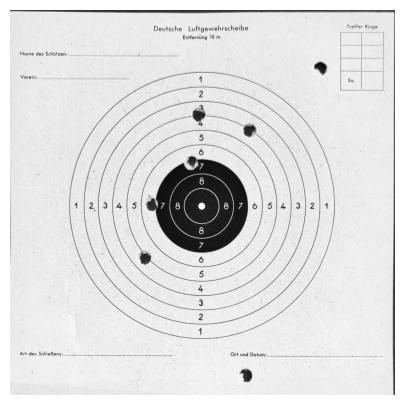

In [97]:
image = io.imread(f'resources/aligned/shot_6.jpg')
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
show_image(img, cmap="gray", size=(5,5))

## Ringerkennung

### 1. CV2 Hough Circle Transformation

In [98]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

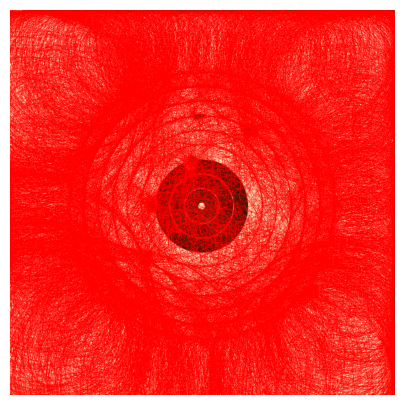

In [89]:
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param1=150, param2=30, minRadius=0, maxRadius=0)
circles = np.round(circles[0, :]).astype("int")
marked = image.copy()
for (x, y, r) in circles:
    output_1 = cv2.circle(marked, (x, y), r, (255, 0, 0), 1)
show_image(marked, size=(5,5))

Sehr langsam (dauert über 2min für ein Bild) und auch noch ziemlich ungenau.

Für Kreise die ungefähr in der Mitte des Bildes sind: 

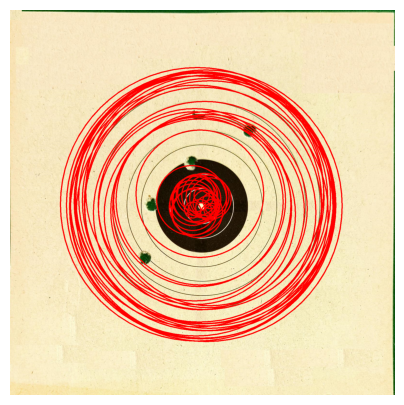

In [90]:
filtered_circles = []
height, width = image.shape[:2]
width = int(width/2)
height = int(height/2)
tollerance = 50
for (x, y, r) in circles:
    if (x > width - tollerance) and (x < width+tollerance) and (y > height-tollerance) and (y < height+tollerance):
        filtered_circles.append((x, y, r))

marked = image.copy()
for (x, y, r) in filtered_circles:
    output_1 = cv2.circle(marked, (x, y), r, (255, 0, 0), 3)
show_image(marked, size=(5, 5))

### 2. Größte Kontur finden

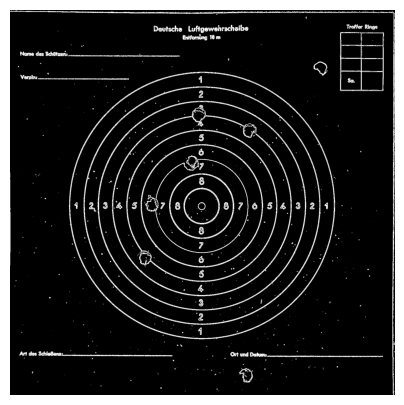

In [99]:
sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# CV2 sobel ist deutlich schneller als selber geschriebener
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255

show_image(sobel, cmap="gray", size=(5,5))

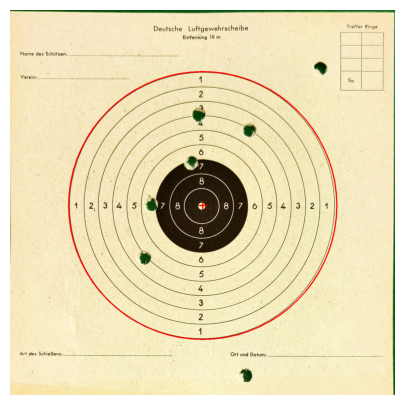

In [100]:
contours, _ = cv2.findContours(sobel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    radius = cv2.minEnclosingCircle(contour)[1]
    area = cv2.contourArea(contour)
    total = area * radius
    if total > biggest_radius:
        biggest_radius = total
        biggest_cntr = contour

# Zentrum der größten Kontur über minimal umschließenden Kreis
(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)
centerX = int(centerX)
centerY = int(centerY)

cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
cv2.circle(marked, (centerX, centerY), int(biggest_radius), (255, 0, 0), 3)
show_image(marked, size=(5,5))

Sehr schnell aber die Kreise sind leider nicht perfekt. Bild muss genau von vorne aufgenommen werden.

### 3. Zentrum über schwarzen Bereich bestimmen und eigene Abwandlung von Hough Circle Transformation

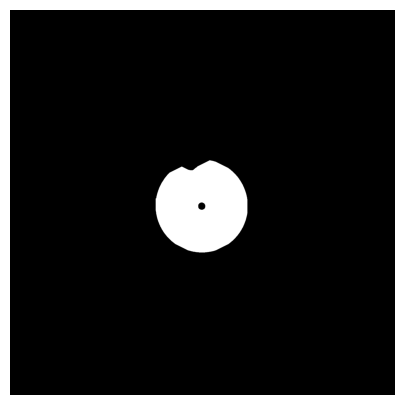

In [106]:
res = gray_image.copy()
res = cv2.GaussianBlur(res, (5, 5), 0)
border_width=50
res[:border_width, :] = 255
res[-border_width:, :] = 255
res[:, :border_width] = 255
res[:, -border_width:] = 255
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel, res, iterations=3)
cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel, res, iterations=25)
threshold = 80
res[res < threshold] = 0
res[res >= threshold] = 255
res = cv2.bitwise_not(res)
show_image(res, cmap="gray", size=(5,5))

2


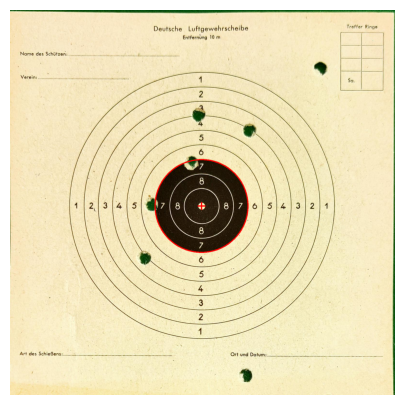

In [113]:
contours, _ = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    radius = cv2.minEnclosingCircle(contour)[1]
    if radius > biggest_radius:
        biggest_radius = radius
        biggest_cntr = contour
print(len(contours))
# Zentrum der größten Kontur über minimal umschließenden Kreis
(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)
centerX = int(centerX)
centerY = int(centerY)
cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
cv2.circle(marked, (centerX, centerY), int(biggest_radius), (255, 0, 0), 3)
show_image(marked, size=(5,5))

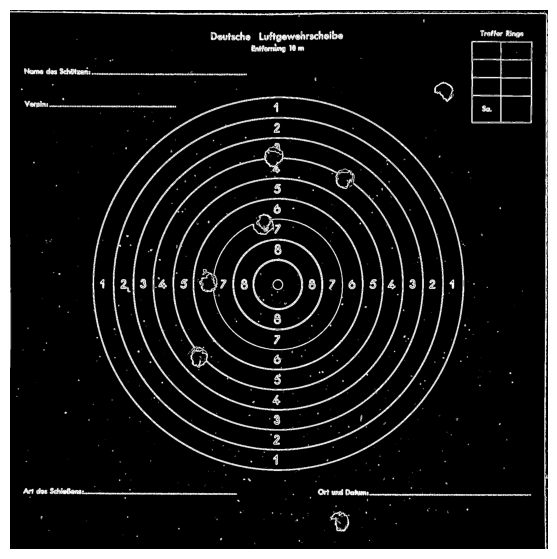

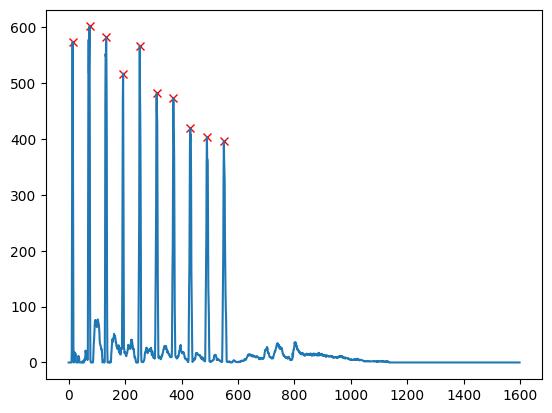

In [114]:
def median_peak_distance(peaks):
    distances = []
    for peak in peaks:
        for peak2 in peaks:
            distances.append(np.abs(peak - peak2))
    return np.median(distances)


def hough_circles_around_center(image, fix):
    height, width = image.shape
    acc_length_factor = 1
    length_acc = width * acc_length_factor
    acc = np.zeros(length_acc)
    x_f, y_f = fix
    for x in range(0, width):
        for y in range(0, height):
            if image[y, x] > 0:
                radius = np.floor(
                    np.sqrt((x_f - x)**2 + (y_f - y)**2) * acc_length_factor).astype("int")
                acc[radius] = acc[radius] + 1

    # Kleiner Radius = weniger Punkte auf dem Kreis
    acc = acc / ((np.arange(len(acc))+1)/acc_length_factor)
    acc = acc * 100
    max = np.max(acc)
    peaks, _ = find_peaks(acc, prominence=1, distance=40, height=0.5*max)

    plt.plot(peaks,  acc[peaks], "xr")
    plt.plot(acc)
    plt.show()

    indices = np.nonzero(acc)
    indices = np.array(indices).astype("int").flatten()
    return (peaks/acc_length_factor).astype("int")


show_image(sobel, cmap='gray', size=(7, 7))
circles = hough_circles_around_center(sobel, (centerX, centerY))

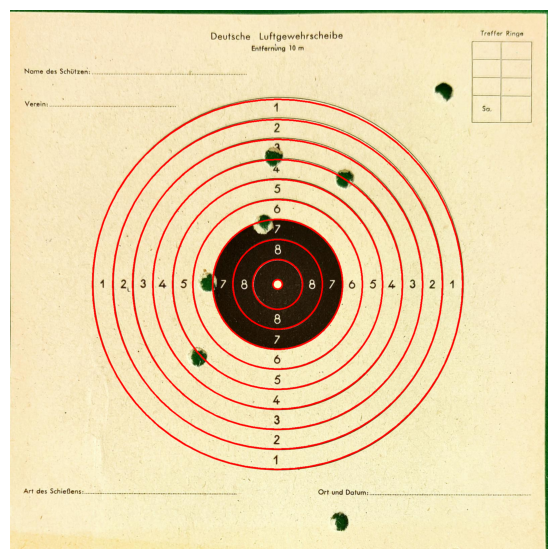

In [115]:
marked = image.copy()
for r in circles: 
    marked = cv2.circle(marked, (centerX, centerY), r, (255, 0, 0), 3)
show_image(marked, size=(7, 7))

Zahlen sind relativ Dick und verhindern dass die Richtigen Kreise gefunden werden